# More About Random Forest
 
*Leonardo Portes, Fev/2022* 
 
---


In this notebook, we will explore two topics: 

1. How to "measure" the relative importance of the features in our data:
     * Random forest feature importance
     * Permutation importance
2. Visualizing the decision tree of a trained classifier



We are going to use the dataset **Iron Ore**. Note that:

* It was explored in week **05**
* We have built SVM, KNN and RF classifiers in week **08**

The first part (loading the model until building the RF classifier) was slightly modified from the week 08 notebook **am1-iron-ore-dataset**.

**ATTENTION** - if running this notebook using JupyterHub, maybe we might need first to install some modules. If so, uncomment the code below and run it. 

In [ ]:
#!pip install pandas numpy matplotlib seaborn sklearn imbalanced-learn

In [1]:
# Standard libraries
import numpy as np  # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # plot nicely =)

# Auxiliar functions
from utils import *

# the following to lines will tell to the python kernel to always update the kernel for every utils.py
# modification, without the need of restarting the kernel.
%load_ext autoreload
%autoreload 2

# using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code
%matplotlib inline

## Loading data

In [2]:
# reading dataset
df = pd.read_csv('../data/iron_ore_study.csv')
df.head()

,FE,SIO2,AL2O3,P
0,58.33,1.95,2.20,0.07
1,57.53,2.45,2.62,0.08
2,57.05,2.94,3.37,0.12
3,56.43,2.95,2.91,0.09
4,57.70,2.89,2.43,0.08


In [3]:
# adding label column

# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if everything is True
df['is_ore'] = np.vstack([
    pd.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, is_ore in split_points
]).sum(axis=0) == 4

df.tail()

,FE,SIO2,AL2O3,P,is_ore
3495,63.14,2.09,1.26,0.05,True
3496,61.56,2.69,1.38,0.05,True
3497,60.33,2.89,1.66,0.05,True
3498,58.30,4.07,1.24,0.03,False
3499,61.00,3.80,1.24,0.03,True


Inspecting data balance. 

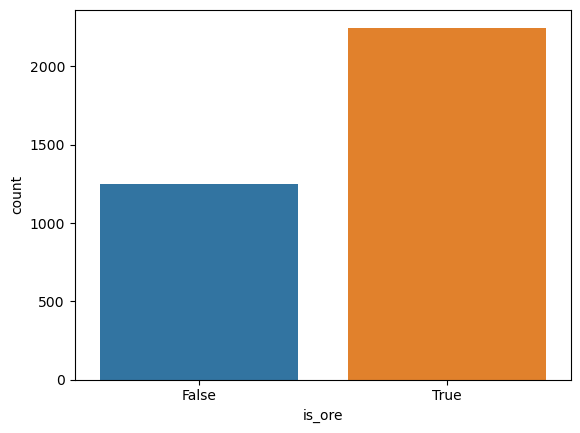

In [4]:
sns.countplot(x='is_ore', data=df);

Storing features and labels.

In [5]:
# Storing features and labels

X = df.iloc[:,:-1].copy(deep=True)  # our features: all columns but the last
y = df["is_ore"].values             # respective labels

unique, counts = np.unique(y, return_counts=True)

print('is ore == {}:'.format(unique[0]), counts[0])
print('is ore == {}:'.format(unique[1]), counts[1])
print('Proportion:', round(counts[0] / counts[1], 2), ': 1')

is ore == False: 1252
is ore == True: 2248
Proportion: 0.56 : 1


Now the features (variables) are stored in the Pandas data frame ```X```, and the associated labels are stored in the Numpy 1-D array ```y```. 

In [6]:
# sanity check!

display(X.head()) # features (or variables)

,FE,SIO2,AL2O3,P
0,58.33,1.95,2.20,0.07
1,57.53,2.45,2.62,0.08
2,57.05,2.94,3.37,0.12
3,56.43,2.95,2.91,0.09
4,57.70,2.89,2.43,0.08


In [7]:
# sanity check! 

y # labels

array([False, False, False, ...,  True, False,  True])

### Splitting the Data into Train and Test Sets

In [8]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3,  random_state=42
)

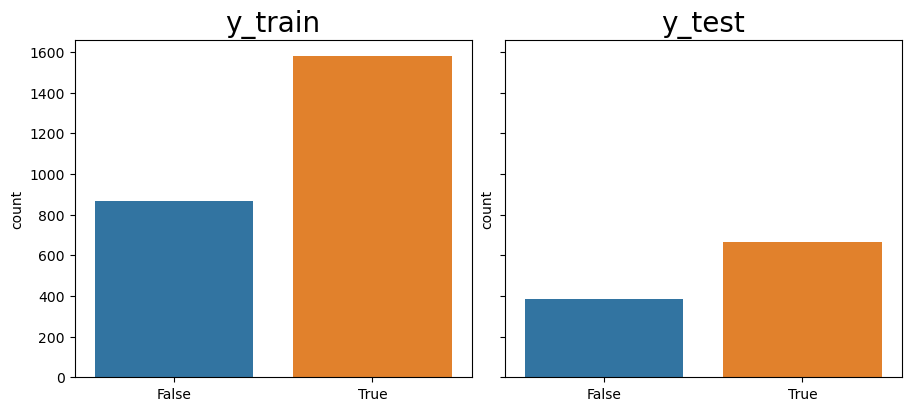

In [9]:
# Sanity check: train test split distribution

fig, axes = plt.subplots(1,2,figsize=(9,4), sharey=True, constrained_layout=True)

i = 0
axes[i].set_title("y_train", fontsize=20)
sns.countplot(x=y_train, ax=axes[i])

i += 1
axes[i].set_title("y_test", fontsize=20)
sns.countplot(x=y_test, ax=axes[i]);

## Random Forest classifier

Let's use a RF with only two trees (i.e., two estimators). You should latter run this notebook again, changing the number of trees to 50 and compare the result. 


* Remember that the RF does not use the concept of distances in a $d$-dimensional space (with $d=$ number of features). So, we do **not** need to standardize the data. 

* If you want to practice with other models such KNN and SVM, remember that you will need to standardize the data. For this, have a look on the week-08 notebooks. 

In [14]:
from sklearn.ensemble import RandomForestClassifier # implements random forest.

n_trees = 2 # number of trees in the forest.

# model definition
model = RandomForestClassifier(n_estimators=n_trees, random_state=42)      

# model training
model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=2, random_state=42)

Prediction using test data:

In [15]:
y_pred = model.predict(x_test)  

Now we will compare our prediction with the ground truth. Remember that both are a sequence of Trues and False values: 

In [16]:
# our predictions
y_pred

array([ True,  True, False, ...,  True, False,  True])

In [18]:
# the actual ground truth
y_test

array([ True,  True, False, ...,  True, False,  True])

## Model evaluation

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  

In [20]:
print(f"RF train accuracy: {model.score(x_train, y_train):.3f}")
print(f"RF test accuracy: {model.score(x_test, y_test):.3f}")

RF train accuracy: 0.999
RF test accuracy: 0.996


We can print a detailed model report!

In [21]:
# Detailed model report

from sklearn import  metrics

print(f"Classification report for the classifier\n"
      f"{classification_report(y_test, y_pred)}\n")

Classification report for the classifier
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       383
        True       1.00      0.99      1.00       667

    accuracy                           1.00      1050
   macro avg       0.99      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050




The above metrics just summarize different nuances of the confusion matrix. Remember to plot that matrix to get more insight!

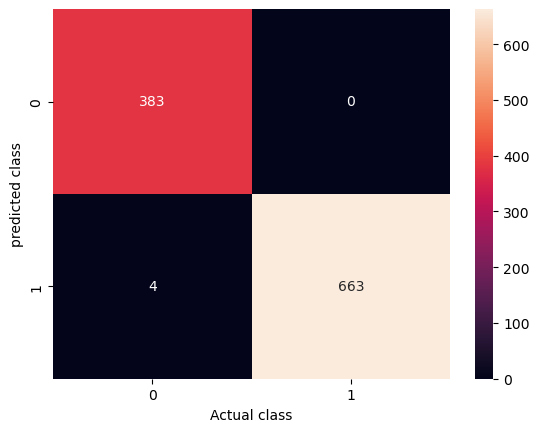

In [22]:
# Confusion matrix

cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Actual class")
plt.ylabel("predicted class");

# "Feature Importance"

For a in-depth discution about Permutation Importance *vs* Random Forest Feature Importance follow this [link](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py).

## Random Forest Feature Importance

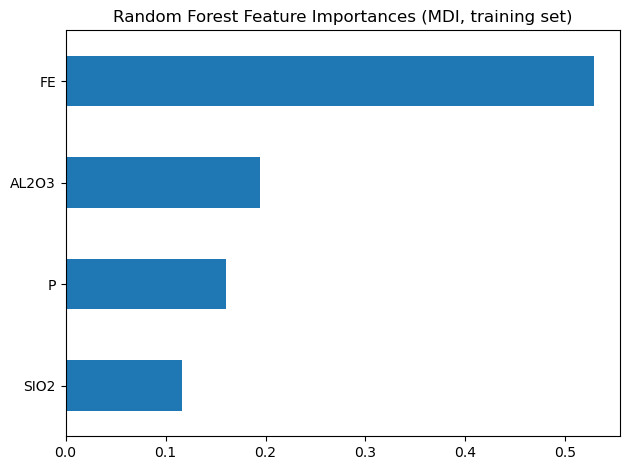

In [24]:
# Random Forest feature importance 
#   from Mean Decrease in Impurity (MDI)

feature_names = X.columns.to_numpy()

# computing and storing result in a Pandas Series
mdi_importances = pd.Series(
    model.feature_importances_, index=feature_names
).sort_values(ascending=True)

# plotting
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI, training set)")
ax.figure.tight_layout()

## Permutation Importance

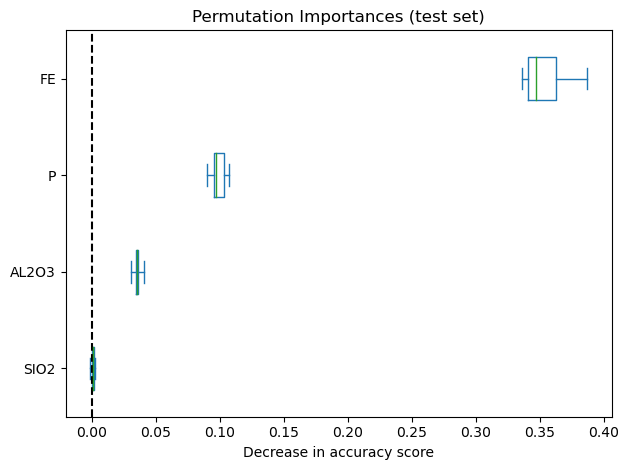

In [25]:
# Permutation Importance

from sklearn.inspection import permutation_importance

# computing permutation importance
pmi_res = permutation_importance(
    model, x_test, y_test, n_repeats=10, 
    random_state=42
)

# Storing result
sorted_importances_idx = pmi_res.importances_mean.argsort()
pmi_importances = pd.DataFrame(
    pmi_res.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx],
)

# plotting

ax = pmi_importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Your turn!

* Using your expert knowledge, discuss the feature importance provided by both methods.


* After a grid search, the best hyper-parameters for the RF model are: {'max_depth': 4, 'max_leaf_nodes': 8, 'n_estimators': 50, 'random_state': 42}. Investigate the changes in performance and feature importance provided by that new, **best** model. 

# Visualizing the decision tree

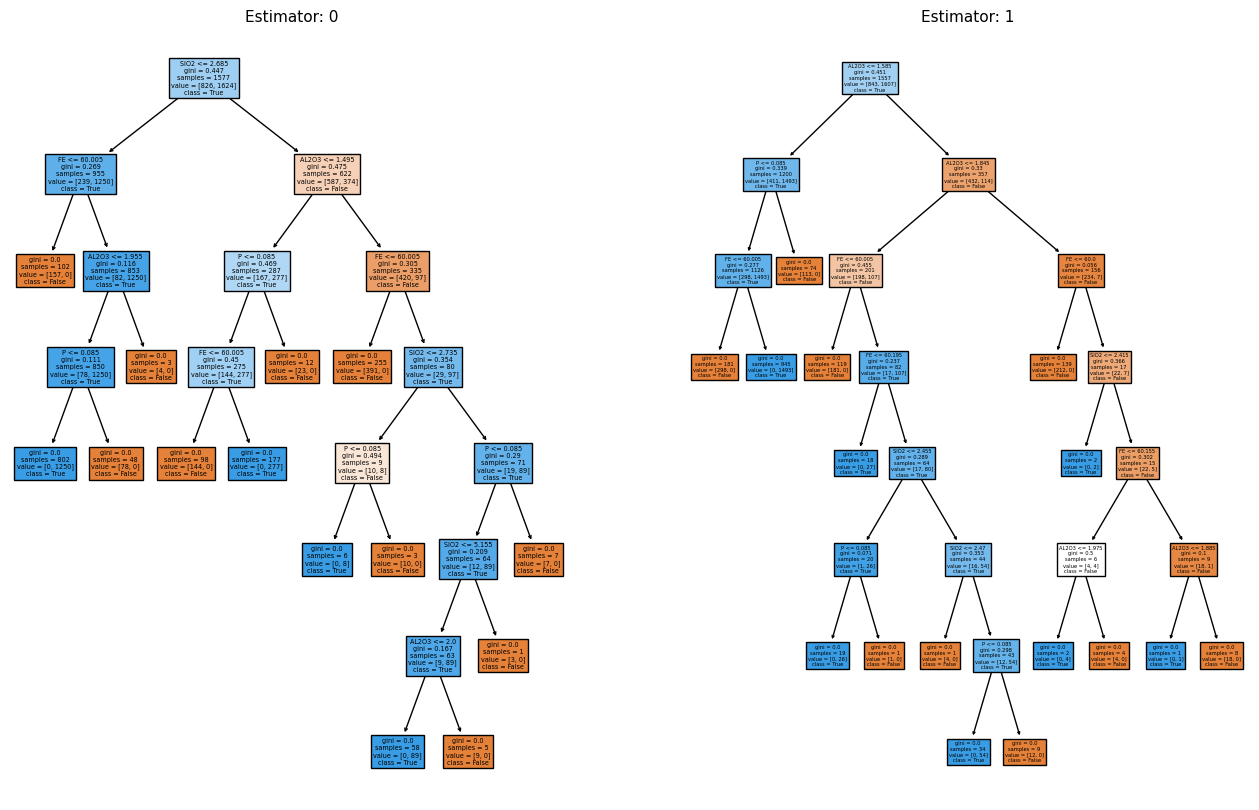

In [26]:
# Visualizing the decision tree

from sklearn import tree

cn= ["%s"%i for i in np.unique(y_train)] #["False","True"]

fig, axes = plt.subplots(1,2,figsize = (16,10))

# plotting only two trees!
for index in range(0, 2):
    tree.plot_tree(model.estimators_[index],
                   feature_names = feature_names, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);
    
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
    
fig.savefig("plotting_decision_trees.pdf")

## Adeddum



### Grid search

In [27]:
# GridSearch

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from time import time


# defining parameter range
param_grid = {'max_depth': [2, 3, 4, 5, 10, 20, 40, 60], 
              'max_leaf_nodes': [2, 4, 6, 8, 16, 32, 64, 128],               
              'n_estimators': [10, 25, 50, 100, 500], 
              'random_state': [42]} 
  

import multiprocessing
n_jobs = multiprocessing.cpu_count() -2
print(n_jobs)


grid = GridSearchCV(RandomForestClassifier(), param_grid,
                    refit = True, verbose = 3, n_jobs=n_jobs)
  
# fitting the model for grid search
tic = time()

grid.fit(x_train, y_train)

elapsed = time() - tic
print("- Elapsed time",elapsed,"(s)")
print("- Elapsed time",elapsed/60,"(min)")
print("- Elapsed time",elapsed/(60*60),"(h)")

34
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 3/5] END max_depth=2, max_leaf_nodes=4, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 3/5] END max_depth=2, max_leaf_nodes=8, n_estimators=50, random_state=42;, score=0.963 total time=   0.1s
[CV 5/5] END max_depth=2, max_leaf_nodes=16, n_estimators=10, random_state=42;, score=0.943 total time=   0.0s
[CV 3/5] END max_depth=2, max_leaf_nodes=16, n_estimators=50, random_state=42;, score=0.963 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=32, n_estimators=10, random_state=42;, score=0.998 total time=   0.0s
[CV 5/5] END max_depth=2, max_leaf_nodes=32, n_estimators=10, random_state=42;, score=0.943 total time=   0.0s
[CV 4/5] END max_depth=2, max_leaf_nodes=32, n_estimators=25, random_state=42;, score=0.955 total time=   0.1s
[CV 3/5] END max_depth=2, max_leaf_nodes=32, n_estimators=50, random_state=42;, score=0.963 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=32, n_

Several RF models, with all combinations of the hyper-parameters we provided, were trainned and evaluated. Below we retrieve the hyper-parameters of the best estimator, and even the **code** to be used to set the best model!

In [29]:
print("- best parameter after tuning")
print(grid.best_params_)
  
print("\n- how our model looks after hyper-parameter tuning")
print(grid.best_estimator_)

- best parameter after tuning
{'max_depth': 4, 'max_leaf_nodes': 8, 'n_estimators': 50, 'random_state': 42}

- how our model looks after hyper-parameter tuning
RandomForestClassifier(max_depth=4, max_leaf_nodes=8, n_estimators=50,
                       random_state=42)


---
Therefore, you could just go back to the trainning cell of this notebook and paste the code above, like this: 

```
model = RandomForestClassifier(max_depth=4, max_leaf_nodes=8, n_estimators=50,
                       random_state=42)
```                   

---

If you need a "in-depth" report about the grid search with a nice output, here it goes: 

In [30]:
df_grid_res = pd.DataFrame(grid.cv_results_)
cols_sel = ['param_max_depth', 'param_max_leaf_nodes', 'param_n_estimators',
       'param_random_state', 'params',
            'mean_test_score','std_test_score', 'rank_test_score']

df_grid_res[cols_sel].sort_values(by ="rank_test_score")

,param_max_depth,param_max_leaf_nodes,param_n_estimators,param_random_state,params,mean_test_score,std_test_score,rank_test_score
159,5,128,500,42,"{'max_depth': 5, 'max_leaf_nodes': 128, 'n_est...",0.999592,0.000816,1
182,10,16,50,42,"{'max_depth': 10, 'max_leaf_nodes': 16, 'n_est...",0.999592,0.000816,1
183,10,16,100,42,"{'max_depth': 10, 'max_leaf_nodes': 16, 'n_est...",0.999592,0.000816,1
184,10,16,500,42,"{'max_depth': 10, 'max_leaf_nodes': 16, 'n_est...",0.999592,0.000816,1
185,10,32,10,42,"{'max_depth': 10, 'max_leaf_nodes': 32, 'n_est...",0.999592,0.000816,1
...,...,...,...,...,...,...,...,...
281,60,2,25,42,"{'max_depth': 60, 'max_leaf_nodes': 2, 'n_esti...",0.950204,0.006657,313
1,2,2,25,42,"{'max_depth': 2, 'max_leaf_nodes': 2, 'n_estim...",0.950204,0.006657,313
81,4,2,25,42,"{'max_depth': 4, 'max_leaf_nodes': 2, 'n_estim...",0.950204,0.006657,313
161,10,2,25,42,"{'max_depth': 10, 'max_leaf_nodes': 2, 'n_esti...",0.950204,0.006657,313


[CV 5/5] END max_depth=2, max_leaf_nodes=4, n_estimators=10, random_state=42;, score=0.943 total time=   0.0s
[CV 5/5] END max_depth=2, max_leaf_nodes=6, n_estimators=500, random_state=42;, score=0.953 total time=   1.1s
[CV 4/5] END max_depth=2, max_leaf_nodes=128, n_estimators=100, random_state=42;, score=0.961 total time=   0.2s
[CV 5/5] END max_depth=3, max_leaf_nodes=2, n_estimators=500, random_state=42;, score=0.943 total time=   1.1s
[CV 1/5] END max_depth=3, max_leaf_nodes=32, n_estimators=500, random_state=42;, score=0.998 total time=   1.1s
[CV 1/5] END max_depth=4, max_leaf_nodes=6, n_estimators=500, random_state=42;, score=0.998 total time=   1.2s
[CV 3/5] END max_depth=4, max_leaf_nodes=128, n_estimators=500, random_state=42;, score=1.000 total time=   1.2s
[CV 2/5] END max_depth=5, max_leaf_nodes=32, n_estimators=10, random_state=42;, score=1.000 total time=   0.0s
[CV 5/5] END max_depth=5, max_leaf_nodes=32, n_estimators=10, random_state=42;, score=1.000 total time=   0.

[CV 3/5] END max_depth=2, max_leaf_nodes=2, n_estimators=500, random_state=42;, score=0.957 total time=   1.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=128, n_estimators=10, random_state=42;, score=0.998 total time=   0.0s
[CV 5/5] END max_depth=2, max_leaf_nodes=128, n_estimators=10, random_state=42;, score=0.943 total time=   0.0s
[CV 4/5] END max_depth=2, max_leaf_nodes=128, n_estimators=25, random_state=42;, score=0.955 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=128, n_estimators=100, random_state=42;, score=0.998 total time=   0.2s
[CV 2/5] END max_depth=3, max_leaf_nodes=2, n_estimators=500, random_state=42;, score=0.959 total time=   1.1s
[CV 4/5] END max_depth=3, max_leaf_nodes=32, n_estimators=100, random_state=42;, score=1.000 total time=   0.2s
[CV 3/5] END max_depth=3, max_leaf_nodes=64, n_estimators=500, random_state=42;, score=1.000 total time=   1.1s
[CV 1/5] END max_depth=4, max_leaf_nodes=8, n_estimators=500, random_state=42;, score=0.998 total time=  

[CV 5/5] END max_depth=2, max_leaf_nodes=2, n_estimators=100, random_state=42;, score=0.943 total time=   0.2s
[CV 3/5] END max_depth=2, max_leaf_nodes=8, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=8, n_estimators=500, random_state=42;, score=0.961 total time=   1.1s
[CV 1/5] END max_depth=3, max_leaf_nodes=2, n_estimators=25, random_state=42;, score=0.945 total time=   0.1s
[CV 1/5] END max_depth=3, max_leaf_nodes=2, n_estimators=100, random_state=42;, score=0.945 total time=   0.2s
[CV 1/5] END max_depth=3, max_leaf_nodes=4, n_estimators=500, random_state=42;, score=0.998 total time=   1.1s
[CV 4/5] END max_depth=3, max_leaf_nodes=64, n_estimators=500, random_state=42;, score=1.000 total time=   1.2s
[CV 3/5] END max_depth=4, max_leaf_nodes=8, n_estimators=500, random_state=42;, score=1.000 total time=   1.2s
[CV 1/5] END max_depth=5, max_leaf_nodes=4, n_estimators=10, random_state=42;, score=0.996 total time=   0.0s
[CV

[CV 4/5] END max_depth=2, max_leaf_nodes=2, n_estimators=50, random_state=42;, score=0.949 total time=   0.1s
[CV 3/5] END max_depth=2, max_leaf_nodes=6, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 3/5] END max_depth=2, max_leaf_nodes=6, n_estimators=500, random_state=42;, score=0.967 total time=   1.1s
[CV 1/5] END max_depth=2, max_leaf_nodes=128, n_estimators=100, random_state=42;, score=0.971 total time=   0.2s
[CV 5/5] END max_depth=3, max_leaf_nodes=2, n_estimators=100, random_state=42;, score=0.943 total time=   0.2s
[CV 5/5] END max_depth=3, max_leaf_nodes=4, n_estimators=100, random_state=42;, score=0.996 total time=   0.2s
[CV 5/5] END max_depth=3, max_leaf_nodes=6, n_estimators=500, random_state=42;, score=0.998 total time=   1.1s
[CV 2/5] END max_depth=3, max_leaf_nodes=128, n_estimators=500, random_state=42;, score=1.000 total time=   1.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=16, n_estimators=500, random_state=42;, score=1.000 total time=   1.0

[CV 2/5] END max_depth=2, max_leaf_nodes=2, n_estimators=25, random_state=42;, score=0.959 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=4, n_estimators=100, random_state=42;, score=0.998 total time=   0.2s
[CV 5/5] END max_depth=2, max_leaf_nodes=6, n_estimators=100, random_state=42;, score=0.953 total time=   0.2s
[CV 4/5] END max_depth=2, max_leaf_nodes=16, n_estimators=50, random_state=42;, score=0.955 total time=   0.1s
[CV 3/5] END max_depth=2, max_leaf_nodes=32, n_estimators=10, random_state=42;, score=0.996 total time=   0.0s
[CV 1/5] END max_depth=2, max_leaf_nodes=32, n_estimators=25, random_state=42;, score=0.994 total time=   0.1s
[CV 5/5] END max_depth=2, max_leaf_nodes=32, n_estimators=25, random_state=42;, score=0.945 total time=   0.1s
[CV 1/5] END max_depth=2, max_leaf_nodes=32, n_estimators=100, random_state=42;, score=0.971 total time=   0.2s
[CV 1/5] END max_depth=2, max_leaf_nodes=64, n_estimators=10, random_state=42;, score=0.994 total time=   0.0s
[

[CV 4/5] END max_depth=2, max_leaf_nodes=2, n_estimators=500, random_state=42;, score=0.949 total time=   1.1s
[CV 4/5] END max_depth=2, max_leaf_nodes=128, n_estimators=10, random_state=42;, score=0.951 total time=   0.0s
[CV 3/5] END max_depth=2, max_leaf_nodes=128, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 5/5] END max_depth=2, max_leaf_nodes=128, n_estimators=50, random_state=42;, score=0.943 total time=   0.1s
[CV 2/5] END max_depth=3, max_leaf_nodes=2, n_estimators=10, random_state=42;, score=0.961 total time=   0.0s
[CV 3/5] END max_depth=3, max_leaf_nodes=2, n_estimators=25, random_state=42;, score=0.957 total time=   0.1s
[CV 3/5] END max_depth=3, max_leaf_nodes=2, n_estimators=100, random_state=42;, score=0.957 total time=   0.2s
[CV 3/5] END max_depth=3, max_leaf_nodes=4, n_estimators=500, random_state=42;, score=1.000 total time=   1.0s
[CV 5/5] END max_depth=3, max_leaf_nodes=64, n_estimators=10, random_state=42;, score=0.990 total time=   0.0s


[CV 3/5] END max_depth=2, max_leaf_nodes=2, n_estimators=50, random_state=42;, score=0.957 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=6, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 1/5] END max_depth=2, max_leaf_nodes=6, n_estimators=500, random_state=42;, score=0.953 total time=   1.1s
[CV 4/5] END max_depth=2, max_leaf_nodes=128, n_estimators=50, random_state=42;, score=0.955 total time=   0.1s
[CV 2/5] END max_depth=3, max_leaf_nodes=2, n_estimators=25, random_state=42;, score=0.959 total time=   0.1s
[CV 5/5] END max_depth=3, max_leaf_nodes=2, n_estimators=50, random_state=42;, score=0.943 total time=   0.1s
[CV 2/5] END max_depth=3, max_leaf_nodes=4, n_estimators=25, random_state=42;, score=0.998 total time=   0.1s
[CV 2/5] END max_depth=3, max_leaf_nodes=4, n_estimators=100, random_state=42;, score=1.000 total time=   0.2s
[CV 1/5] END max_depth=3, max_leaf_nodes=6, n_estimators=500, random_state=42;, score=0.998 total time=   1.1s
[CV 5

[CV 2/5] END max_depth=2, max_leaf_nodes=4, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=8, n_estimators=100, random_state=42;, score=0.998 total time=   0.2s
[CV 1/5] END max_depth=2, max_leaf_nodes=16, n_estimators=500, random_state=42;, score=0.953 total time=   1.1s
[CV 5/5] END max_depth=3, max_leaf_nodes=4, n_estimators=10, random_state=42;, score=0.990 total time=   0.0s
[CV 4/5] END max_depth=3, max_leaf_nodes=4, n_estimators=25, random_state=42;, score=0.996 total time=   0.0s
[CV 5/5] END max_depth=3, max_leaf_nodes=4, n_estimators=50, random_state=42;, score=0.994 total time=   0.1s
[CV 4/5] END max_depth=3, max_leaf_nodes=6, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 5/5] END max_depth=3, max_leaf_nodes=6, n_estimators=50, random_state=42;, score=0.998 total time=   0.1s
[CV 4/5] END max_depth=3, max_leaf_nodes=8, n_estimators=10, random_state=42;, score=0.996 total time=   0.0s
[CV 4/5

[CV 1/5] END max_depth=2, max_leaf_nodes=4, n_estimators=25, random_state=42;, score=0.994 total time=   0.0s
[CV 2/5] END max_depth=2, max_leaf_nodes=6, n_estimators=500, random_state=42;, score=0.961 total time=   1.1s
[CV 3/5] END max_depth=2, max_leaf_nodes=128, n_estimators=100, random_state=42;, score=0.990 total time=   0.2s
[CV 1/5] END max_depth=3, max_leaf_nodes=2, n_estimators=500, random_state=42;, score=0.945 total time=   1.1s
[CV 2/5] END max_depth=3, max_leaf_nodes=32, n_estimators=100, random_state=42;, score=1.000 total time=   0.2s
[CV 5/5] END max_depth=3, max_leaf_nodes=64, n_estimators=100, random_state=42;, score=0.998 total time=   0.2s
[CV 5/5] END max_depth=3, max_leaf_nodes=128, n_estimators=500, random_state=42;, score=0.998 total time=   1.0s
[CV 5/5] END max_depth=4, max_leaf_nodes=16, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 5/5] END max_depth=4, max_leaf_nodes=16, n_estimators=50, random_state=42;, score=0.998 total time=   0

[CV 2/5] END max_depth=60, max_leaf_nodes=4, n_estimators=500, random_state=42;, score=1.000 total time=   1.1s
[CV 2/5] END max_depth=60, max_leaf_nodes=64, n_estimators=500, random_state=42;, score=1.000 total time=   1.0s
[CV 2/5] END max_depth=2, max_leaf_nodes=2, n_estimators=10, random_state=42;, score=0.961 total time=   0.0s
[CV 2/5] END max_depth=2, max_leaf_nodes=4, n_estimators=50, random_state=42;, score=0.959 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=4, n_estimators=500, random_state=42;, score=0.961 total time=   1.1s
[CV 1/5] END max_depth=2, max_leaf_nodes=64, n_estimators=500, random_state=42;, score=0.953 total time=   1.1s
[CV 4/5] END max_depth=3, max_leaf_nodes=16, n_estimators=10, random_state=42;, score=0.996 total time=   0.0s
[CV 3/5] END max_depth=3, max_leaf_nodes=16, n_estimators=25, random_state=42;, score=1.000 total time=   0.1s
[CV 4/5] END max_depth=3, max_leaf_nodes=16, n_estimators=50, random_state=42;, score=1.000 total time=   0.1s

[CV 1/5] END max_depth=2, max_leaf_nodes=2, n_estimators=50, random_state=42;, score=0.945 total time=   0.1s
[CV 1/5] END max_depth=2, max_leaf_nodes=6, n_estimators=10, random_state=42;, score=0.994 total time=   0.0s
[CV 3/5] END max_depth=2, max_leaf_nodes=6, n_estimators=10, random_state=42;, score=0.996 total time=   0.0s
[CV 4/5] END max_depth=2, max_leaf_nodes=6, n_estimators=25, random_state=42;, score=0.955 total time=   0.1s
[CV 1/5] END max_depth=2, max_leaf_nodes=8, n_estimators=10, random_state=42;, score=0.994 total time=   0.0s
[CV 4/5] END max_depth=2, max_leaf_nodes=8, n_estimators=10, random_state=42;, score=0.951 total time=   0.0s
[CV 5/5] END max_depth=2, max_leaf_nodes=8, n_estimators=25, random_state=42;, score=0.945 total time=   0.1s
[CV 4/5] END max_depth=2, max_leaf_nodes=8, n_estimators=500, random_state=42;, score=0.951 total time=   1.0s
[CV 1/5] END max_depth=2, max_leaf_nodes=128, n_estimators=500, random_state=42;, score=0.953 total time=   1.1s
[CV 1/

[CV 5/5] END max_depth=2, max_leaf_nodes=2, n_estimators=50, random_state=42;, score=0.943 total time=   0.1s
[CV 1/5] END max_depth=2, max_leaf_nodes=6, n_estimators=50, random_state=42;, score=0.951 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=8, n_estimators=50, random_state=42;, score=0.959 total time=   0.1s
[CV 2/5] END max_depth=2, max_leaf_nodes=16, n_estimators=10, random_state=42;, score=0.998 total time=   0.0s
[CV 3/5] END max_depth=2, max_leaf_nodes=16, n_estimators=25, random_state=42;, score=0.996 total time=   0.1s
[CV 3/5] END max_depth=2, max_leaf_nodes=16, n_estimators=100, random_state=42;, score=0.990 total time=   0.2s
[CV 2/5] END max_depth=2, max_leaf_nodes=32, n_estimators=100, random_state=42;, score=0.998 total time=   0.2s
[CV 2/5] END max_depth=2, max_leaf_nodes=64, n_estimators=10, random_state=42;, score=0.998 total time=   0.0s
[CV 1/5] END max_depth=2, max_leaf_nodes=64, n_estimators=25, random_state=42;, score=0.994 total time=   0.1s
[C

### Correlations | scatter matrix

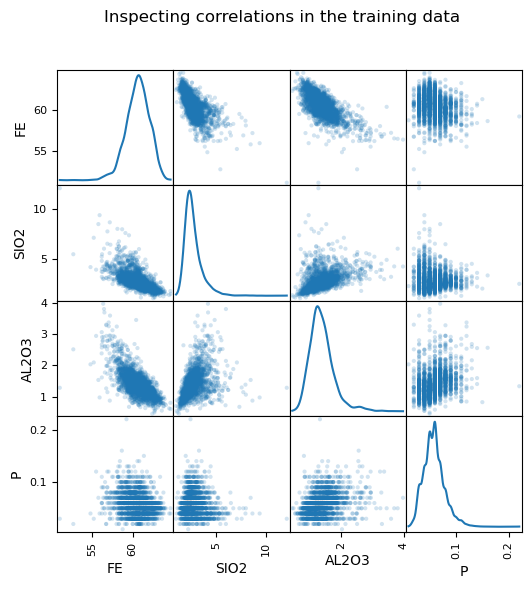

In [31]:
# Scatter matrix

from pandas.plotting import scatter_matrix

sm = scatter_matrix(x_train, 
               alpha=0.2, figsize=(6, 6), diagonal="kde");

            
fig=plt.gcf()
fig.suptitle("Inspecting correlations in the training data");